In [2]:
import io
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

## Carregamento dos dados

In [3]:
dct = {}
dct['codigo'] = 'soja'

In [4]:
df = pd.read_pickle(f'../dados/cepea-{dct["codigo"]}.p')

---

## Análise Exploratória dos dados

In [5]:
df['cotacao_dolar'] = df.preco_real / df.preco_dolar
df['preco_diff1'] = df.preco_dolar.diff()
df # O missing value gerado será automaticamente eliminado no slice abaixo

,preco_real,preco_dolar,cotacao_dolar,preco_diff1
data,,,,
13/03/2006,27.66,12.96,2.134259,NaN
14/03/2006,27.45,12.91,2.126259,-0.05
15/03/2006,27.58,13.00,2.121538,0.09
16/03/2006,26.97,12.78,2.110329,-0.22
17/03/2006,26.96,12.68,2.126183,-0.10
...,...,...,...,...
22/12/2020,150.93,29.22,5.165298,-0.25
23/12/2020,150.91,29.03,5.198415,-0.19
28/12/2020,149.98,28.63,5.238561,-0.40


In [6]:
# Converte index para data
df.index = pd.to_datetime(df.index, format='%d/%m/%Y')

# Slice para somente o período desejado
df = df['01/01/2007':'01/01/2021']

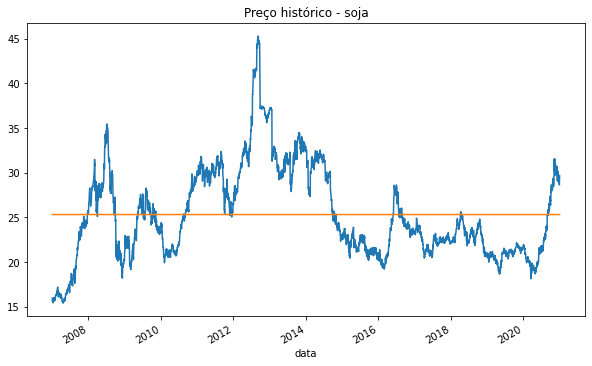

In [7]:
# Gráfico de preços em dólar
copy = df.copy()
copy['media'] = df.preco_dolar.mean()
copy.preco_dolar.plot(figsize=(10,6))
copy.media.plot()
plt.title(f'Preço histórico - {dct["codigo"]}')
plt.show()

<AxesSubplot:title={'center':'Histograma - soja'}>

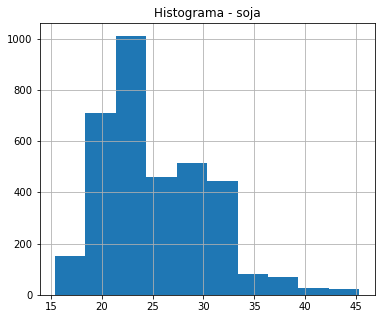

In [8]:
plt.title(f'Histograma - {dct["codigo"]}')
df.preco_dolar.hist(figsize=(6,5))

In [9]:
df.preco_dolar.describe()

count    3492.000000
mean       25.315238
std         5.171868
min        15.400000
25%        21.410000
50%        23.920000
75%        29.280000
max        45.320000
Name: preco_dolar, dtype: float64

#### Tomando a 1ª Diferença

<AxesSubplot:title={'center':'Histograma - soja - 1ª Diferença'}>

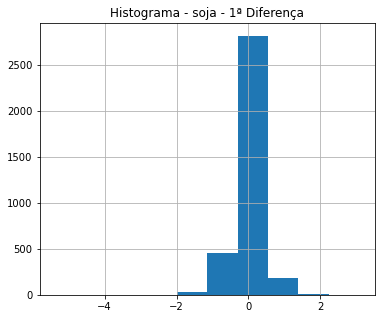

In [10]:
plt.title(f'Histograma - {dct["codigo"]} - 1ª Diferença')
df.preco_diff1.hist(figsize=(6,5))

<AxesSubplot:title={'center':'Preço histórico - soja - 1ª Diferença'}, xlabel='data'>

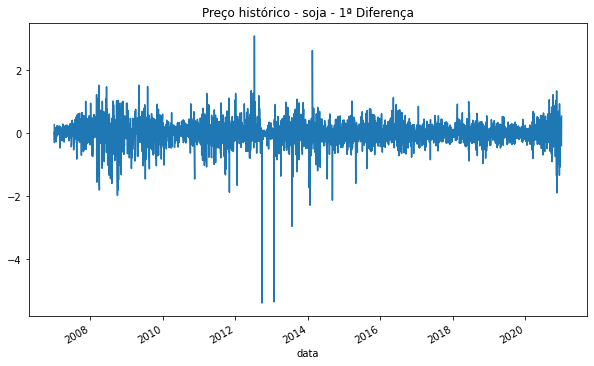

In [11]:
plt.title(f'Preço histórico - {dct["codigo"]} - 1ª Diferença')
df.preco_diff1.plot(figsize=(10,6))

In [12]:
def adf_test(X):
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [13]:
# ADF TEST - Série de Preço dolarizado
adf_test(df.preco_dolar)

ADF Statistic: -2.531736
p-value: 0.107942
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [14]:
# ADF TEST - Série de Preço dolarizado
adf_test(np.log(df.preco_dolar))

ADF Statistic: -2.666996
p-value: 0.079926
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [15]:
# ADF TEST - Primeira Diferença
adf_test(df.preco_diff1)

ADF Statistic: -59.913073
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [25]:
def acf_pacf(series, name=None):
    fig = plt.figure(figsize=(6,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(series,lags=10, ax=ax1)
    fig.tight_layout()

    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(series,lags=10, ax=ax2)
    fig.tight_layout()
    plt.show()
    
    # Scatter plot entre (t) e (t-1)
    plt.figure(figsize=(6,6))
    if name:
        plt.title(f"(t) vs. (t+1) para {name}")
    pd.plotting.lag_plot(series, lag=1)

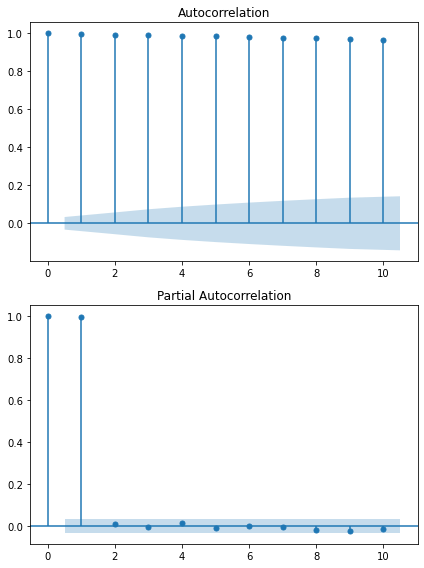

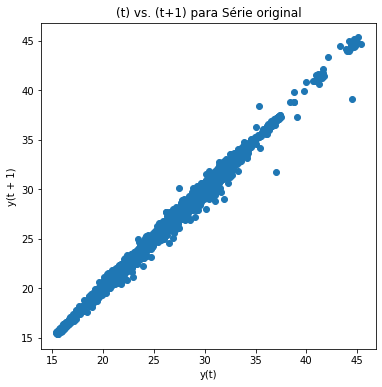

In [26]:
# ACF e PACF - preço dolarizado
acf_pacf(df.preco_dolar, "Série original")

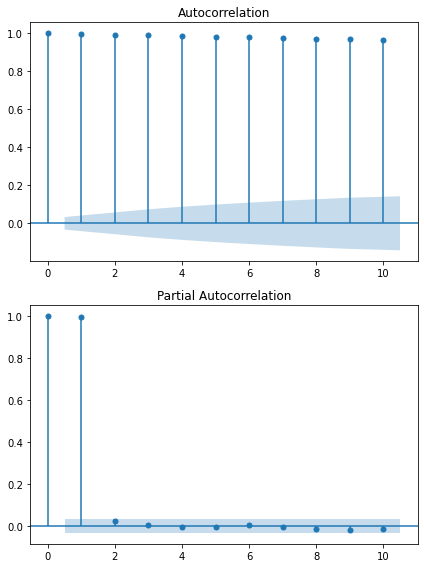

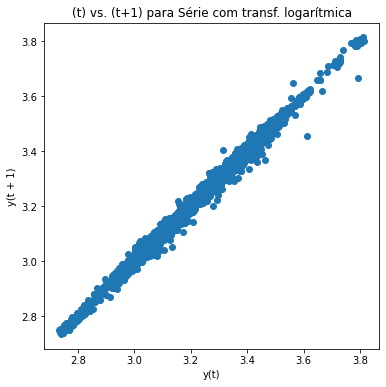

In [27]:
# ACF e PACF - preço dolarizado com transf. logaritmica
acf_pacf(np.log(df.preco_dolar), "Série com transf. logarítmica")

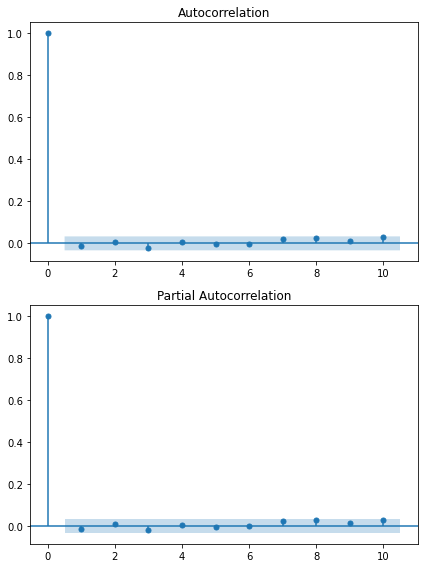

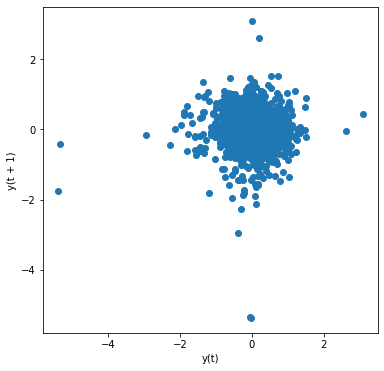

In [19]:
# ACF e PACF - preço dolarizado
acf_pacf(df.preco_diff1)

---

#### Decomposição da série

In [20]:
# Como uma possível sazonalidade nos preços deve ter ciclo anual, com variação mensal, 
# faremos o resample da série para a média de cada mês
df_mes = df.resample('MS').mean()
df.isnull().any()

preco_real       False
preco_dolar      False
cotacao_dolar    False
preco_diff1      False
dtype: bool

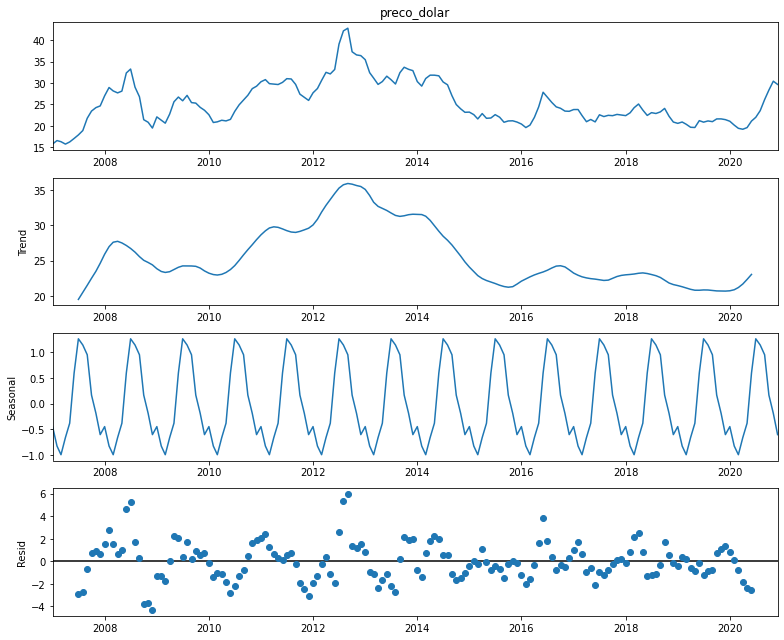

In [21]:
# Decomposição da série mensal em tendência, sazonalidade e resíduos
series = df_mes.preco_dolar

rcParams['figure.figsize'] = 11, 9
result = seasonal_decompose(series, model='additive')
result.plot()
plt.show()

In [28]:
# ADF TEST - Série de Preço dolarizado mensal
adf_test(df_mes.preco_dolar)

ADF Statistic: -3.123904
p-value: 0.024834
Critical Values:
	1%: -3.470
	5%: -2.879
	10%: -2.576


In [22]:
a_r = result.resid.max()-result.resid.min()
a_s = result.seasonal.max()-result.seasonal.min()
print(f'Amplitude residual de {dct["codigo"]}: {"{:.2f}".format(a_r)}')
print(f'Amplitude sazonal de {dct["codigo"]}: {"{:.2f}".format(a_s)}')
print(f'Relação amplitude residual / sazonal:  {"{:.2f}".format(a_r/a_s)}')

Amplitude residual de soja: 10.28
Amplitude sazonal de soja: 2.26
Relação amplitude residual / sazonal:  4.55
